In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=d606b4e4ce82fc6d3a453b9ccabd2ee218d6cfa09af311a402acdb6dfaf54683
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [21]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
seed = 1
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
set_seed(1)

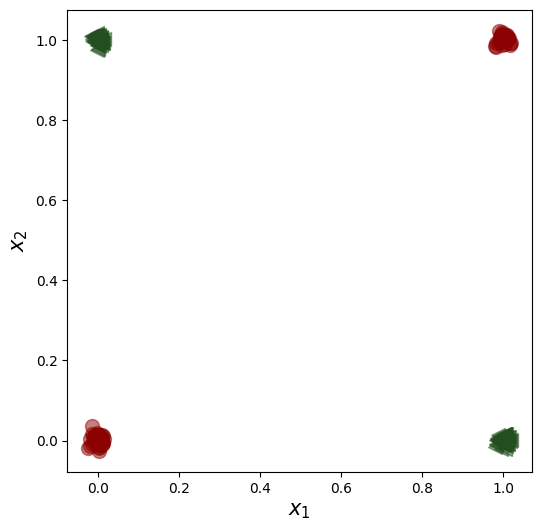

In [22]:
# Setting a seed to make reproducible results
np.random.seed(seed)
torch.manual_seed(seed)

# Generate two random features as 0/1 (indicator variables)
x1 = (np.random.uniform(size=200) < 0.5).astype(int)
x2 = (np.random.uniform(size=200) < 0.5).astype(int)

# Creating the dataset from the features
x = np.array([x1, x2]).T

# Setting up XOR formula
y = x1 + x2 - 2 * x1 * x2

# Train and test split - use some of the data to train the neural network and
# the rest to validate our results
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_test = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_test = torch.tensor(y[n_train:], dtype=torch.float32)

# Visualizing our data (adding some jitter)
fig = plt.figure(figsize=(6, 6))
x_jittered = x + np.random.normal(scale=0.009, size=x.shape)
plt.plot(x_jittered[y==0, 0],
         x_jittered[y==0, 1], 'o', alpha=0.5, markersize=10, c='#8b0000')
plt.plot(x_jittered[y==1, 0],
         x_jittered[y==1, 1], '<', alpha=0.5, markersize=10, c='#234f1e')
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

In [23]:
#Change your runtime type to a GPU to activate "cuda" as a device - will make your code so much faster
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# Hyperparameters
input_size = 2 # How many features do we have?
lr = 0.05 # Factor we will multiply our gradients by in SGD, how much we want to let what we learn change our model parameters
batch_size = 2 # How many examples do you want look at on each update?

In [24]:
# Creating TensorDataset and DataLoader objects from our data
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

# DataLoader allows efficient iteration over data in batches
# - train_dl shuffles the training data to prevent any overfitting
# - test_dl does not shuffle the test data so it is in its original order
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

In [25]:
# Creating our MLP
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MultiLayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList([ # Accomplishes the same thing but less code
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(input_size, hidden_size), # New Linear Layer
            nn.GELU(), # Comes after ReLU
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=1)
        ])

    def forward(self, x):
        for layer in self.module_list: # Accomplishes the same thing but less code
            x = layer(x)
        return x

MLP = MultiLayerPerceptron(input_size, 2, 2).to(device) # Change the Output Size to 2
MLP

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

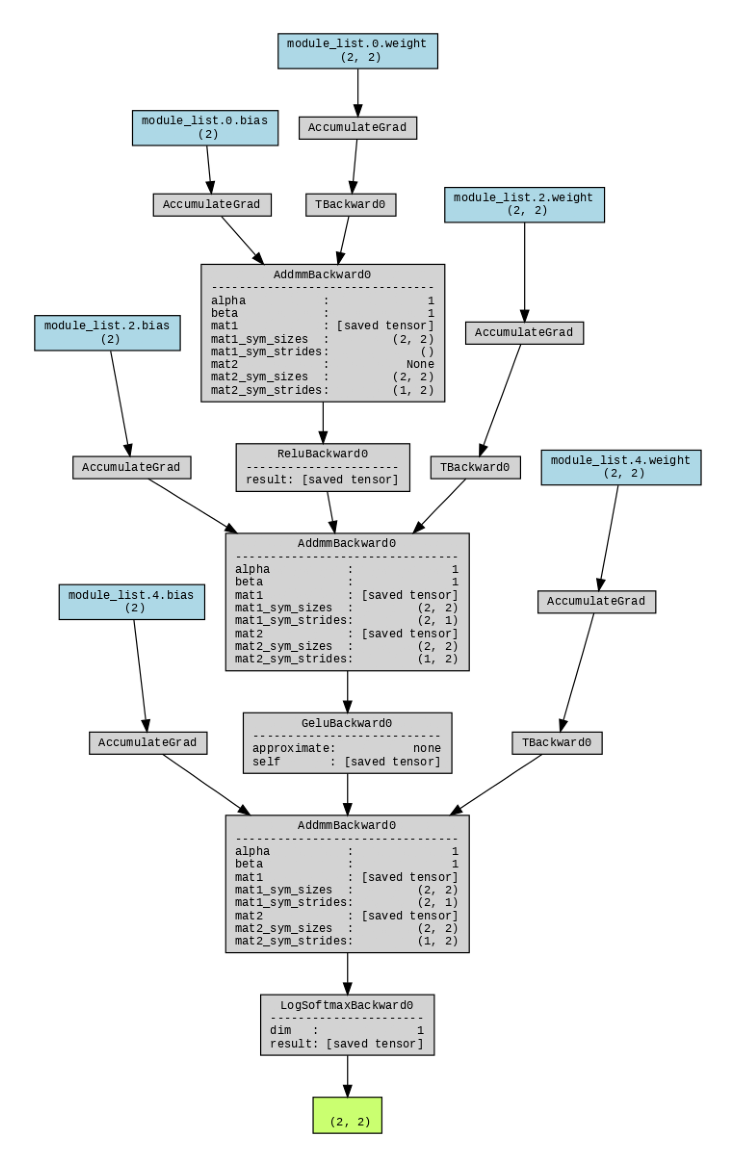

In [26]:
# Let's look at the computational graph for this new model
# How does the hidden size change the model's computational graph?

plt.rcParams['figure.dpi'] = 300
inputs, _ = next(iter(train_dl))
yhat = MLP(inputs.to(device))
graph = make_dot(yhat, params=dict(MLP.named_parameters()), show_attrs=True)

graph.render("viz", format="png")

img = plt.imread("viz.png")
plt.imshow(img)
plt.axis('off')
plt.show()
plt.rcParams['figure.dpi'] = 100

In [27]:
# Resetting our variables!
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

criterion = torch.nn.NLLLoss() # Change to NLLLoss
optimizer = torch.optim.SGD(MLP.parameters(), lr=lr)
losses = []

# Training loop
for epoch in range(100):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    zero_grad_ave = 0 # New variable created
    batch_total = 0 # New variable created

    for inputs, labels in train_dl:
        labels = labels.long() # Labels have to be class indices
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        zero_grad = 0
        for para in MLP.parameters():
          zero_grad += (para.grad == 0).sum().item()

        zero_grad_ave += zero_grad
        batch_total += 1
        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    losses.append(avg_loss)

    ave_0_gra_per_batch = zero_grad_ave / batch_total
    print(f"Epoch {epoch}, Loss: {avg_loss}, Average Zero Gradients: {ave_0_gra_per_batch}")

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss}")

print("--------------")
print(f"Train Accuracy: {correct_predictions / total_samples}")

Epoch 0, Loss: 0.349356404542923, Average Zero Gradients: 5.56
Epoch 0, Loss: 0.349356404542923
Epoch 1, Loss: 0.34714898467063904, Average Zero Gradients: 5.62
Epoch 2, Loss: 0.34575074970722197, Average Zero Gradients: 5.58
Epoch 3, Loss: 0.3464410799741745, Average Zero Gradients: 5.56
Epoch 4, Loss: 0.3474117958545685, Average Zero Gradients: 5.62
Epoch 5, Loss: 0.34669958651065824, Average Zero Gradients: 5.52
Epoch 6, Loss: 0.3469956308603287, Average Zero Gradients: 5.44
Epoch 7, Loss: 0.3451700860261917, Average Zero Gradients: 5.6
Epoch 8, Loss: 0.34744997441768644, Average Zero Gradients: 5.54
Epoch 9, Loss: 0.34632698237895965, Average Zero Gradients: 5.6
Epoch 10, Loss: 0.34513160526752473, Average Zero Gradients: 5.6
Epoch 10, Loss: 0.34513160526752473
Epoch 11, Loss: 0.3469132339954376, Average Zero Gradients: 5.58
Epoch 12, Loss: 0.34670538902282716, Average Zero Gradients: 5.6
Epoch 13, Loss: 0.3460048961639404, Average Zero Gradients: 5.58
Epoch 14, Loss: 0.34647052645

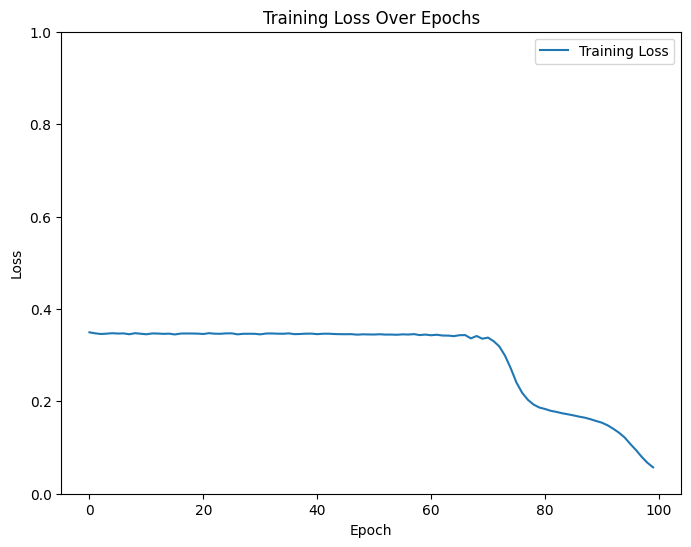

In [28]:
# Plotting the MLP training loss
plt.figure(figsize=(8, 6))
plt.plot(range(100), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [32]:
# Set model to evaluation mode
MLP.eval()

# Initialize a counters for correct and total predictions
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP(inputs)

        # Apply a threshold of 0.5 for binary classification and fix the shape
        predicted = (outputs > 0.5).float().squeeze()

        correct += (predicted == labels).sum().item()
        total += labels.size(0)


# Calculate accuracy
accuracy = correct / total

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 86.00%


In [33]:
import imageio.v2 as imageio
import os
from IPython.display import Image, display

MLP2 = MultiLayerPerceptron(input_size, 2, 2).to(device)
MLP2

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [34]:
# Resetting our variables!
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(MLP2.parameters(), lr=0.1)
image_files = []

# Training loop
for epoch in range(100):
    total_loss = 0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP2(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    #print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dl):.4f}")

    with torch.no_grad():
        x_min, x_max = -0.5, 1.5
        y_min, y_max = -0.5, 1.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
        Z = torch.argmax(MLP2(grid), dim=1).cpu().numpy().reshape(xx.shape)

        plt.figure()
        plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.7, cmap=plt.cm.Spectral)
        plt.scatter(x_test[:, 0],
                    x_test[:, 1],
                    c=y_test,
                    edgecolors='k', marker='o', s=100)
        plt.title(f"MLP Learned Decision Boundary - Epoch {epoch + 1}")
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")

        # Save image
        image_file = f"epoch_{epoch + 1}.png"
        plt.savefig(image_file)
        image_files.append(image_file)
        plt.close()